# Coronavirus _tweets_ Sentiment Analysis

This notebook aims to present a full scope solution using NLP techiniques to address the objective of analysing rather _tweets_ (in English) about the _Coronavirus_ are __positve__, __negative__ or __neutral__.
In this task I'll use a dataset obtained from Kaggle (available at: https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification) to train and validate a model that tells the sentiment of a tweet based on its content. This is a broad challenge, with multiple possible solutions and deals with a updated and relevant theme.

## Data preparation

In [1]:
# installing additional packages
!pip install emoji
!pip install transformers

  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171030 sha256=c14641e087b657922de04cf0cf6a3579dcbff8909dddcb0ebe2f6d35851ef53e
  Stored in directory: c:\users\chafu\appdata\local\pip\cache\wheels\5e\8c\80\c3646df8201ba6f5070297fe3779a4b70265d0bfd961c15302
Successfully built emoji


In [2]:
# libraries to manipulate and visualize data
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# libraries to process data
import re, string
import emoji
import nltk
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# libraries to extract features
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# libraries for modeling
# Naive Bayes para modelo base
from sklearn.naive_bayes import MultinomialNB

# neural networls
import tensorflow as tf
from tensorflow import keras

# transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

# libraries to analyse the models' performance
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# random seed for reproducibility
seed=42

# plots style
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 432x288 with 0 Axes>

In [4]:
# function to plot the confusion matrixes
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [5]:
# load the csv files into Pandas DataFrames
df = pd.read_csv('/content/Corona_NLP_train.csv', encoding='ISO-8859-1')
print(df.shape)
df_test = pd.read_csv('/content/Corona_NLP_test.csv')
print(df_test.shape)

(41157, 6)
(3798, 6)


In [6]:
# Exhibition of the dataset's first few rows
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
# .info() method shows NaN count and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [8]:
# 'TweetAt' filed conversion to the Pandas' datetime format
df['TweetAt'] = pd.to_datetime(df['TweetAt'])

In [9]:
# duplicate check
df.drop_duplicates(subset='OriginalTweet',inplace=True)
print(df.shape)

(41157, 6)


## Preprocessing

In [10]:
# to make things simple, let's only keep the columns 'OriginalTweet' e 'Sentiment'
df = df[['OriginalTweet','Sentiment']]
df_test = df_test[['OriginalTweet','Sentiment']]

In [11]:
## Functions to handle with texts

# remove emojis
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text)

# remove punctuation, hyperlinks, mentions (@) and characters that designate paragraphs (\r\n)
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() # remove \n and \r and set lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) # remove hyperlinks and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) # remove non-utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§' # remove special characters
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

# clears hashtags at the end of the sentence and keeps the ones in the middle without the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove o símbolo hashtags (#) das palavras no meio da frase
    return new_tweet2

# filter special characters & and $
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

# remove multiple spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

In [12]:
# applies the handling functions defined above
texts_new = []
for t in df.OriginalTweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))
df['text_clean'] = texts_new

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  """


In [13]:
# ditto for the test set
texts_new_test = []
for t in df_test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))
df_test['text_clean'] = texts_new_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  """


In [14]:
# displays some records with treated texts
df['text_clean'][1:8].values

array(['advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order',
       'coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid19 outbreak',
       'my food stock is not the only one which is empty please dont panic there will be enough food for everyone if you do not take more than you need stay calm stay safe covid19france covid19 covid19 coronavirus confinement confinementotal confinementgeneral',
       'me ready to go at supermarket during the covid19 outbreak not because im paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please dont panic it causes shortage coronavirusfrance restezchezvous stayathome confinement',
       'as news of the regions first confirmed covid19 case came out of sullivan county last week people 


Now we will create a variable with the character count of the treated tweet in order to verify if the treatments removed a lot of text

In [15]:
# treino
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

df['text_len'] = text_len

# teste
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

df_test['text_len'] = text_len_test

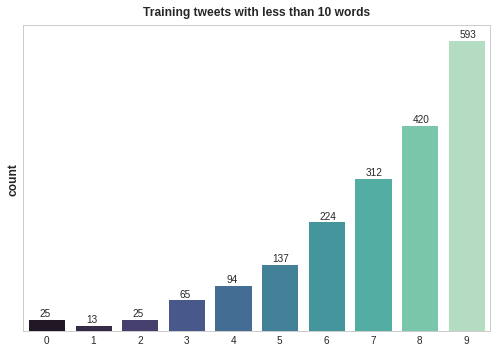

In [16]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
plt.ylabel('count')
plt.xlabel('')
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+5))
plt.show()

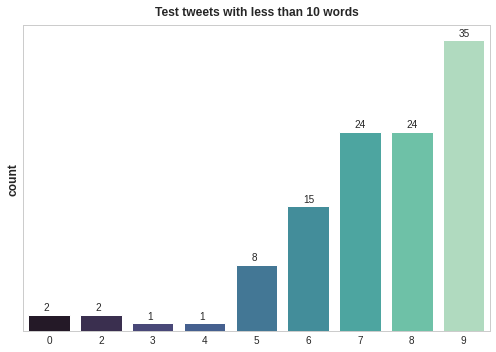

In [17]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
plt.ylabel('count')
plt.xlabel('')
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+0.5))
plt.show()

We can notice that there are tweets with few words (even with none). This is due to the fact that some tweets contain only mentions, hashtags and hyperlinks.
These records will be deleted for further analysis.

In [18]:
print(f" DF SHAPE antes da remoção: {df.shape}")
print(f" DF TEST SHAPE antes da remoção: {df_test.shape}")

df = df[df['text_len'] > 4]
df_test = df_test[df_test['text_len'] > 4]

print(f" DF SHAPE após a remoção: {df.shape}")
print(f" DF TEST SHAPE após a remoção: {df_test.shape}")

 DF SHAPE antes da remoção: (41157, 4)
 DF TEST SHAPE antes da remoção: (3798, 4)
 DF SHAPE após a remoção: (40935, 4)
 DF TEST SHAPE após a remoção: (3792, 4)


In [19]:
# next we will apply the tokenization of the texts
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)
print(f"Maior extensão de frase tokenizada: {max_len}")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Maior extensão de frase tokenizada: 100


In [20]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    
max_len=np.max(token_lens_test)
print(f"Maior extensão de frase tokenizada: {max_len}")

Maior extensão de frase tokenizada: 96


In [21]:
# let's check the texts that have a lot of tokens (> 80):
token_lens = []
for i, txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 1622, TEXT: zsah policie proti spekulantm s roukami na mj popud hejtman steckho kraje ve spoluprci s podle krizovho zkona zajistil tm 700 tisrouek od firmy kter je mla dodat na zdravotnkm ale na posledn chvli se snaila navyovat cenu spolutozvladneme
INDEX: 13623, TEXT: hoy aplaudo a mi segunda familia aplaudoanuestrosheroes aquellos con los que he compartido tantas noches de trabajo y tanta alegra s que como siempre dan todo por el bien de su comunidad presidente por ellos tambin cuarentenanacionalya cuidemosalosquecuidan
INDEX: 16548, TEXT: bir mddettir spermarketlerin lojistik hizmeti avusturya ordusu desteiyle yaplyor dn corona tedavisi iin 22 milyon luk bir aratrma gelitirme btesi aklad hkmet geen hafta da 35 milyon luk 2 yardm paketi aklanmt viyanadan haberler bu kadar
INDEX: 36953, TEXT: 11 nisan cumartesi itibariyle bbnin tm hizmetleri sokaa kma serbestisi olanlar iin devam edecek halk ekmek ve hamidiye su 100 retime geti bb tm stanbulun gda ihtiyacna yetecek kapasitededi

In [22]:
# these sentences are not in english, so let's remove them
df['token_lens'] = token_lens

df = df.sort_values(by='token_lens', ascending=False)
df.head(8)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
1638,ZÃ¡sah policie proti spekulant?m s rouÂkami. ...,Neutral,zsah policie proti spekulantm s roukami na mj ...,39,100
37156,11 Nisan Cumartesi itibariyle ?BBÂnin tÃ¼m hi...,Neutral,11 nisan cumartesi itibariyle bbnin tm hizmetl...,39,98
16632,Bir mÃ¼ddettir sÃ¼permarketlerin lojistik hizm...,Neutral,bir mddettir spermarketlerin lojistik hizmeti ...,36,92
13691,Hoy aplaudo a mi segunda familia #AplaudoANues...,Neutral,hoy aplaudo a mi segunda familia aplaudoanuest...,38,84
27005,Supermercados Econo confirman que un empleado ...,Neutral,supermercados econo confirman que un empleado ...,39,80
14593,"Na, wer war denn da am Werk? Gestern Nachmitta...",Extremely Negative,na wer war denn da am werk gestern nachmittag ...,37,80
28899,Kindly contact Us bamy global merchandise for ...,Positive,kindly contact us bamy global merchandise for ...,37,80
11213,Keine WertgegenstÃ¤nde im Fahrzeug lassen! - D...,Negative,keine wertgegenstnde im fahrzeug lassen diesen...,33,79


In [23]:
df = df.iloc[12:]
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
0,COVID-19's impact on consumer and business beh...,Neutral,covid19s impact on consumer and business behavior,7,12
1,@MillieReagan @CarthyNc @annesheridan1 @SimonH...,Extremely Negative,what makes you say the spread of flu is uncont...,33,40
2,Washing hands with SOAP fights Here s why it...,Neutral,washing hands with soap fights here s why it w...,12,14
3,It was a nice surprise. #coronavirus #toiletpa...,Positive,it was a nice surprise coronavirus toiletpaper...,12,26
4,Police patrolling at Leeds supermarket to enfo...,Neutral,police patrolling at leeds supermarket to enfo...,9,13


In [24]:
# ditto for the test set

token_lens_test = []
for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 286, TEXT: so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to buy some food to stock txnid093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7f my b
INDEX: 345, TEXT: informoval jsem zstupce vech obchodnch etzc o aktulnch opatench vldy etzce jsou zsobovny na 95 take nen dvod panikait zsoby potravin fakt nedojdou nen opravdu dvod dnes obsadit a vykoupit supermarkety
INDEX: 2380, TEXT: ahora seguid llorando por el papel higinico que no he comprado porque an tengo seguid creando histeria y preocupacin poniendo fotos de gente en pnico y estanteras vacas que yo seguir yendo a comercios responsables de barrio donde nos cuidan hoy y siempre gracias


In [25]:
df_test['token_lens'] = token_lens_test
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
286,@Rhett800cc So hard to decide??. As much as I ...,Negative,so hard to decide as much as i want to hodl my...,38,96
2383,Ahora seguid llorando por el papel higiénico (...,Negative,ahora seguid llorando por el papel higinico qu...,44,94
345,Informoval jsem zástupce vech obchodních ?et?...,Neutral,informoval jsem zstupce vech obchodnch etzc o ...,31,86
1485,DTF-Dont Touch Face\r\r\nDWBH-Do Wash Both Ha...,Extremely Negative,dtfdont touch face dwbhdo wash both hands gtfo...,42,77
1209,Im in the DC/Maryland/Virginia (DMV) area &am...,Positive,im in the dcmarylandvirginia dmv area amphave ...,45,74


In [26]:
df_test = df_test.iloc[5:]
df_test = df_test.sample(frac=1).reset_index(drop=True)
df_test.head(3)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
0,My grocery store in Montreal. It is usually co...,Neutral,my grocery store in montreal it is usually com...,13,24
1,The line up at 12.39am Saturday morning at Col...,Negative,the line up at 1239am saturday morning at cole...,28,48
2,Britain s food retailers published an open let...,Negative,britain s food retailers published an open let...,23,26


## Preparation for modeling

Now that the texts are clean, let's adjust the labels of the classes of the variable of interest ('Sentiment') to be only with the classes 'negative', 'positive' and 'neutral

In [27]:
df['Sentiment'].value_counts()

Positive              11381
Negative               9889
Neutral                7560
Extremely Positive     6618
Extremely Negative     5475
Name: Sentiment, dtype: int64

In [28]:
# in addition to reducing the number of classes, we are now going to assign numerical values ​​to them

df['Sentiment'] = df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

df['Sentiment'].value_counts()

2    17999
0    15364
1     7560
Name: Sentiment, dtype: int64

In [29]:
# note that the three classes are unbalanced, so we will apply an oversampling technique to avoid bias
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment'])
train_os['Sentiment'].value_counts()

1    17999
0    17999
2    17999
Name: Sentiment, dtype: int64

In [30]:
# now we can separate the training set into two new sets for training (90%) and validation (10%)

X = train_os['text_clean'].values
y = train_os['Sentiment'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [31]:
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

In this type of problem, it is common that the binarization of the classes of the response variable improves the performance of the models.

In [32]:
# cópias com a variável resposta codificada em números 
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

# binarização
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 48597
VALIDATION DATA: 5400
TESTING DATA: 3787


## Modeling

### Base Model: Naive Bayes Classifier

In [33]:
# Let's define a base model to use as a reference for more complex models.
# First we will create a new feature applying the TF-IDF technique of tokenized tweets
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [34]:
# Defines the Naive Bayes classifier. Then perform the training, make predictions of the validation subset and visualize the results
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tf, y_train_le)
nb_pred = nb_clf.predict(X_test_tf)

print('\tRelatório de classificação para o modelo Naive Bayes:\n\n', classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Relatório de classificação para o modelo Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.71      0.78      0.74      1629
     Neutral       0.59      0.44      0.50       614
    Positive       0.74      0.73      0.73      1544

    accuracy                           0.70      3787
   macro avg       0.68      0.65      0.66      3787
weighted avg       0.70      0.70      0.70      3787



The performance of the base model is not bad. The F1-score is above 70% for the majority classes ('Positive' and 'Negative'), but only reaches 50% for the 'Neutral' class.
The overall accuracy is 70%, considered a satisfactory result.

### BERT Transformer Network

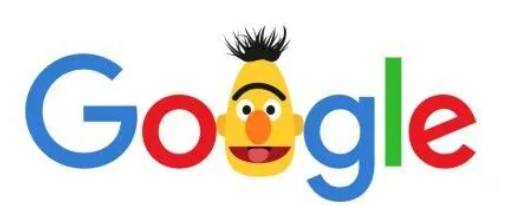

In [35]:
MAX_LEN = 128

In [36]:
def tokenize(data,max_len=MAX_LEN) :
  input_ids = []
  attention_masks = []
  for i in range(len(data)):
      encoded = tokenizer.encode_plus(
          data[i],
          add_special_tokens=True,
          max_length=MAX_LEN,
          padding='max_length',
          return_attention_mask=True
      )
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

In [37]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [38]:
# let's import a pre-trained model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [39]:
# Then define a function to add an output layer with three neurons (one for each classification)

def create_model(bert_model, max_len=MAX_LEN):
  '''parameters:
  opt: optimizer
  loss: loss function
  accuracy: training metric
  '''

  opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
  loss = tf.keras.losses.CategoricalCrossentropy()
  accuracy = tf.keras.metrics.CategoricalAccuracy()

  input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
  attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')
  embeddings = bert_model([input_ids, attention_masks])[1]
  output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
  model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)
  model.compile(opt, loss=loss, metrics=accuracy)

  return model

In [40]:
# instantiates the model and displays the network summary
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [41]:
# training

history_bert = model.fit([train_input_ids, train_attention_masks], y_train,
                         validation_data=([val_input_ids, val_attention_masks], y_valid), epochs=4, batch_size=32)

Epoch 1/4
1519/1519 [==============================] - 774s 500ms/step - loss: 0.5613 - categorical_accuracy: 0.7737 - val_loss: 0.3810 - val_categorical_accuracy: 0.8693
Epoch 2/4
1519/1519 [==============================] - 756s 498ms/step - loss: 0.2967 - categorical_accuracy: 0.8928 - val_loss: 0.2617 - val_categorical_accuracy: 0.9091
Epoch 3/4
1519/1519 [==============================] - 755s 497ms/step - loss: 0.1987 - categorical_accuracy: 0.9294 - val_loss: 0.2342 - val_categorical_accuracy: 0.9217
Epoch 4/4
1519/1519 [==============================] - 755s 497ms/step - loss: 0.1393 - categorical_accuracy: 0.9521 - val_loss: 0.2698 - val_categorical_accuracy: 0.9187


In [44]:
test_loss, test_acc = model.evaluate([val_input_ids, val_attention_masks],  y_valid, verbose=2)
print('\nTest accuracy:', test_acc)

169/169 - 28s - loss: 0.2698 - categorical_accuracy: 0.9187 - 28s/epoch - 167ms/step

Test accuracy: 0.9187036752700806


The training was performed using Google Colab IDE with GPU allocation. Each training epoch took about 13 minutes to run reaching about 91.87% accuracy.

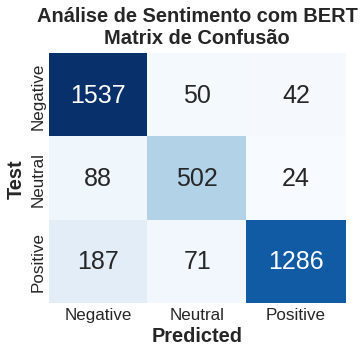

In [42]:
# previsions with BERT
result_bert = model.predict([test_input_ids,test_attention_masks])

y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'Análise de Sentimento com BERT\nMatrix de Confusão')

In [45]:
print('\tRelatório de classificação para o modelo BERT:\n\n', classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Relatório de classificação para o modelo BERT:

               precision    recall  f1-score   support

    Negative       0.85      0.94      0.89      1629
     Neutral       0.81      0.82      0.81       614
    Positive       0.95      0.83      0.89      1544

   micro avg       0.88      0.88      0.88      3787
   macro avg       0.87      0.86      0.86      3787
weighted avg       0.88      0.88      0.88      3787
 samples avg       0.88      0.88      0.88      3787



The performance report above demonstrates that the f1-score of each class was fairly balanced and above 80% for all classes. This implies that the model developed is capable of classifying tweets of all classes very well.
The overall accuracy was 88%, well above the result of the base model.

## Conclusion

In this notebook we developed a sentiment analysis for tweets about Coronavirus using NLP techniques and we developed a model that uses a pre-trained and adapted BERT neural network to classify the sentiments of tweets. This model presented very satisfactory performance, with an accuracy of 88%.